# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Normal-Methods" data-toc-modified-id="Normal-Methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Normal Methods</a></div><div class="lev1 toc-item"><a href="#New-likelihood" data-toc-modified-id="New-likelihood-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>New likelihood</a></div><div class="lev2 toc-item"><a href="#Try-as-two-networks-to-freeze-weights" data-toc-modified-id="Try-as-two-networks-to-freeze-weights-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Try as two networks to freeze weights</a></div>

Author: Bryan Ostdiek

This notebook attempts to make a network for regression which not only outputs its prediction, but also how confident it is in the prediction.

# Imports

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
from scipy.stats import norm, multivariate_normal, truncnorm
from scipy.optimize import leastsq, minimize

from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib


from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


plt.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

/home/dropulic/.conda/envs/venv_ML/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


This is just to test if I can get the loss function (and reshaping) to work such that the neural network output is a predicition and a confidence level. Thus, for each point, I want the network to output two numbers. However, the Y_labels that are the truth value do not have a confidence level associated with it, so the shape will be different. Keras will complain about this in the loss function (I think).

Start with just a simmple 1D regression problem. The function will be an exponentially falling function, but there will be some error in the y-values (randomness) that grows with the size of x.

In [2]:
def MakeData(NSamples):
    xdata = np.random.rand(NSamples)*5
    ydata = 10* np.exp(-xdata) + 0.1 * (np.random.randn(NSamples) * (xdata + 0.01))
    
    return np.array([xdata, ydata])
    

In [3]:
data = MakeData(1000)

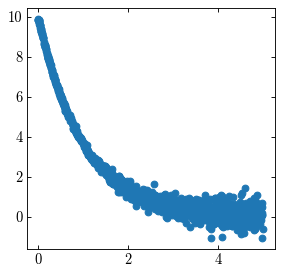

In [4]:
plt.scatter(data[0, :], data[1, :])
# plt.yscale('log')
plt.show()

# Normal Methods

In [5]:
model = Sequential()
model.add(Dense(8, input_dim=1, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(data[0,:], data[1, :], 
          epochs=500,
          batch_size=64,
          validation_split=0.1,
          verbose=2)

In [7]:
test_data = MakeData(500)

In [8]:
TestPreds = model.predict(test_data[0,:])

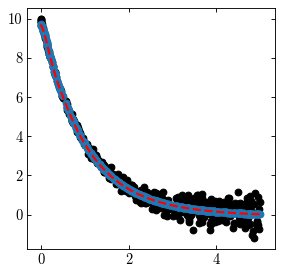

In [9]:
plt.figure()
plt.scatter(test_data[0,:], test_data[1,:], color='k')
plt.scatter(test_data[0,:], TestPreds)
plt.plot(np.linspace(0,5,100), model.predict(np.linspace(0,5,100)),
         color='r',
         ls='--',lw=2,
         zorder=3
        )

So the above network is clearly capable of fitting the exponential well, and it does not seem to be trying to over fit and hit all of the data perfectly. Now I want to change the loss function.

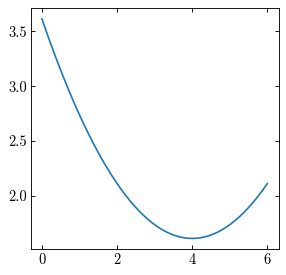

In [10]:
means = np.array([1.0,2.0,3.0,4.0])
stds = np.array([.5, 1, 1.5, 2])


plt.plot(np.linspace(0,6), -norm.logpdf(np.linspace(0,6), loc=4, scale=2))

In [11]:
norm.pdf(means, loc=means, scale=stds)

array([0.79788456, 0.39894228, 0.26596152, 0.19947114])

# New likelihood

In [12]:
from keras import backend as K

In [13]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1])
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    return K.mean(ARG - PREFACT)
    

In [14]:
def ConstantLikelihoodFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    ARG = -K.square(X - LOC) / (2.0)
    return K.mean(-ARG)
    

In [15]:
model2 = Sequential()
model2.add(Dense(16, input_dim=1, activation='tanh'))
model2.add(Dense(16, activation='tanh'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(2))

model2.compile(optimizer='adam', loss=LikelihoodLossFunction)

In [16]:
print(np.vstack([data[1, :],np.ones(data.shape[1])]).T)

[[ 0.5389204   1.        ]
 [ 0.33536517  1.        ]
 [-0.34331672  1.        ]
 ...
 [ 4.17459488  1.        ]
 [ 0.14473265  1.        ]
 [-0.160965    1.        ]]


In [17]:
model2.fit(data[0, :], np.vstack([data[1, :],
                                  np.ones(data.shape[1])
                                  ]).T,
          epochs=5000,
          batch_size=64,
          validation_split=0.1,
          verbose=0)

In [18]:
TestPreds2 = model2.predict(test_data[0,:])



In [19]:
TestPreds2[:5]
print(TestPreds2.shape)

(500, 2)


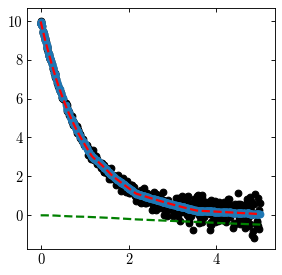

In [20]:
TestPreds2 = model2.predict(test_data[0,:])
plt.figure()
plt.scatter(test_data[0,:], test_data[1,:], color='k')
plt.scatter(test_data[0,:], TestPreds2[:,0])
plt.plot(np.linspace(0,5,100), model2.predict(np.linspace(0,5,100))[:,0],
         color='r',
         ls='--',lw=2,
         zorder=3
        )
plt.plot(np.linspace(0,5,100), model2.predict(np.linspace(0,5,100))[:,1],
         color='g',
         ls='--',lw=2,
         zorder=3
        )

Training one network with two outputs seems tricky, although the shapes are about right. Not sure what to do about the negative confidence. Maybe having a relu for the confidence and a linear for the mean estimate would be better. To do this, try a network made of two parts.

## Try as two networks to freeze weights

In [21]:
from keras.layers import Input, Dense, Merge, Lambda, Concatenate
from keras.models import Model

In [22]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
inputs = Input(shape=(1,))
MeanEst = Dense(8, activation='tanh')(inputs)
MeanEst = Dense(8, activation='tanh')(MeanEst)
MeanEst = Dense(4, activation='tanh')(MeanEst)
MeanEst = Dense(1, activation='linear')(MeanEst)
MeanModel = Model(inputs=[inputs], outputs=MeanEst)

ConfEst = Dense(8, activation='tanh')(inputs)
ConfEst = Dense(8, activation='tanh')(ConfEst)
ConfEst = Dense(4, activation='tanh')(ConfEst)
ConfEst = Dense(1, activation='relu')(ConfEst)
ConfModel = Model(inputs=inputs, outputs=ConfEst)

ConfModel = Model(inputs=inputs, outputs=ConfEst)

CombinedSub = Concatenate(axis=-1)([MeanModel(inputs), ConfModel(inputs)])
CombinedModel = Model(inputs=inputs, outputs=CombinedSub)

In [23]:
CombinedModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            129         input_1[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 1)            129         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           model_1[1][0]                    
                                                                 model_3[1][0]                    
Total para

First train the mean estimator

In [36]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodFunction,
                      optimizer='adam'
                     )

CombinedModel.fit(data[0,:], data[1,:],
                  epochs=2000,
                  batch_size=256,
                  validation_split=0.1,
                  verbose=0
                 )

Now train the confidence estimator

In [37]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihhodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit(data[0,:], data[1,:],
                  epochs=400,
                  batch_size=256,
                  validation_split=0.1,
                  verbose=0
                 )

In [38]:
# ConfModel.trainable = False
# MeanModel.trainable = True
# CombinedModel.compile(loss=LikelihhodLossFunction,
#                       optimizer='adam'
#                      )

# CombinedModel.fit(data[0,:], data[1,:],
#                   epochs=2000,
#                   batch_size=512,
#                   validation_split=0.1,
#                   verbose=0
#                  )

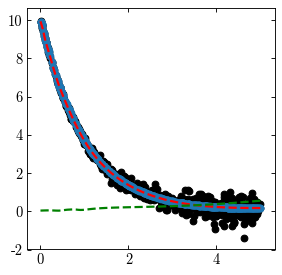

In [39]:
TestPreds2 = CombinedModel.predict(test_data[0,:])
plt.figure()
plt.scatter(test_data[0,:], test_data[1,:], color='k')
plt.scatter(test_data[0,:], TestPreds2[:,0])
plt.plot(np.linspace(0,5,100), CombinedModel.predict(np.linspace(0,5,100))[:,0],
         color='r',
         ls='--',lw=2,
         zorder=3
        )
plt.plot(np.linspace(0,5,100), CombinedModel.predict(np.linspace(0,5,100))[:,1],
         color='g',
         ls='--',lw=2,
         zorder=3
        )

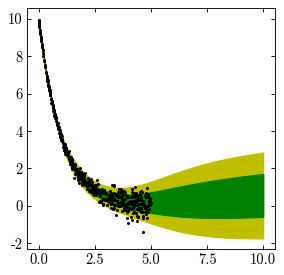

In [40]:
xspace=np.linspace(0,10,100)
plt.fill_between(xspace, 
                 CombinedModel.predict(xspace)[:,0] + 2 * CombinedModel.predict(xspace)[:,1],
                 CombinedModel.predict(xspace)[:,0] - 2 * CombinedModel.predict(xspace)[:,1],
                 color='y'
                )
plt.fill_between(xspace, 
                 CombinedModel.predict(xspace)[:,0] + CombinedModel.predict(xspace)[:,1],
                 CombinedModel.predict(xspace)[:,0] - CombinedModel.predict(xspace)[:,1],
                 color='g'
                )

plt.scatter(test_data[0,:], test_data[1,:], color='k', s=3)

When going to unseen data, the uncertainty seems to be growing!